In [115]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [116]:
Assembly = openmc.Model()

In [117]:
# materials
uo2 = openmc.Material(1,'Fuel')
uo2.add_element('U',1,enrichment= 5.)
uo2.add_element('O',2)
uo2.set_density('g/cm3',10.)
h2o = openmc.Material(2, 'Water')
h2o.add_elements_from_formula('H2O')
h2o.set_density('g/cm3',1.)
zirc = openmc.Material(3,'Zirconium')
zirc.add_element('Zr',1)
zirc.set_density('g/cm3',5.)
Assembly.materials = openmc.Materials([uo2,h2o,zirc])

In [118]:
#geometry
def centroids(r,w):
    '''
    inputs: 
        r : radius of fuel rods
        w : width of assembly 

    returns: 
        2D array of centroids
        1st column is x, 2nd column is y
    '''
    index = int(w/2/r)
    extra = w % (2*r)
    width_per = extra/index
    array = []
    for j in range(index):
        for i in range(index):
            array.append([width_per/2+r+i*(2*r+width_per),width_per/2+r+j*(2*r+width_per)])
    
            
    return array

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

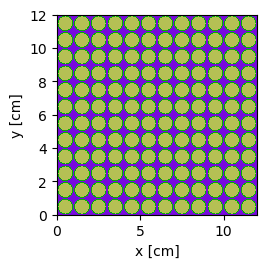

In [155]:
fuel_outer_radius = .413
clad_outer_radius = fuel_outer_radius+.057
fuel_top = 90.0
fuel_bottom = -90.0
width = 12.0
max_index = len(fuel_cylinders)
rod_centroids = centroids(clad_outer_radius,width)
fuel_cylinders = [openmc.ZCylinder(surface_id = i+1,r = fuel_outer_radius,x0 = x, y0 = y) for i,(x,y) in enumerate(rod_centroids)]
clad_cylinders = [openmc.ZCylinder(surface_id = max_index + i+1,r = clad_outer_radius,x0 = x, y0 = y) for i,(x,y) in enumerate(rod_centroids)]
bottom_plane = openmc.ZPlane(z0=fuel_bottom, boundary_type = 'reflective')
top_plane = openmc.ZPlane(z0=fuel_top, boundary_type = 'reflective')
left_plane = openmc.XPlane(x0 = 0,boundary_type = 'vacuum')
right_plane = openmc.XPlane(x0 = width,boundary_type = 'reflective')
back_plane = openmc.YPlane(y0 = width,boundary_type = 'reflective')
front_plane = openmc.YPlane(y0 = 0,boundary_type = 'vacuum')
pinbounds = -top_plane & +bottom_plane 
total_bounds = +left_plane &-right_plane &+front_plane &-back_plane


max_index = len(fuel_cylinders)
water_region = total_bounds & pinbounds
for cyl in clad_cylinders:
    water_region &= +cyl
fuel_cells = [openmc.Cell(cell_id = i+1, region = -fuel_cylinders[i] &pinbounds,fill = uo2) for i in range(max_index)]
clad_cells = [openmc.Cell(cell_id = max_index+2+i, region = +fuel_cylinders[i] & -clad_cylinders[i]&pinbounds,fill = zirc) for i in range(max_index)]
water_cell = openmc.Cell(cell_id = clad_cells[-1].id + 1, region = water_region, fill = h2o)

cells = fuel_cells
cells.extend(clad_cells)
cells.append(water_cell)
universe = openmc.Universe(cells = cells)
Assembly.geometry = openmc.Geometry(universe)
universe.plot(color_by='material',width = (12,12),origin = (6,6,0))

In [180]:
Assembly.settings.batches = 400
Assembly.settings.inactive = 200
Assembly.settings.particles = 10000
Assembly.settings.source = openmc.Source(space=openmc.stats.Box(lower_left= [0,0,-90],upper_right=[12,12,90], only_fissionable=True))
mesh = openmc.RegularMesh()
mesh.lower_left = (0, 0)
mesh.upper_right = (12, 12)
mesh.dimension = (600, 600)

heat = openmc.Tally()
mesh_filter = openmc.MeshFilter(mesh)
heat.scores = ['kappa-fission']
heat.filters = [mesh_filter]
Assembly.tallies = [heat]

In [181]:
statepoint = Assembly.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

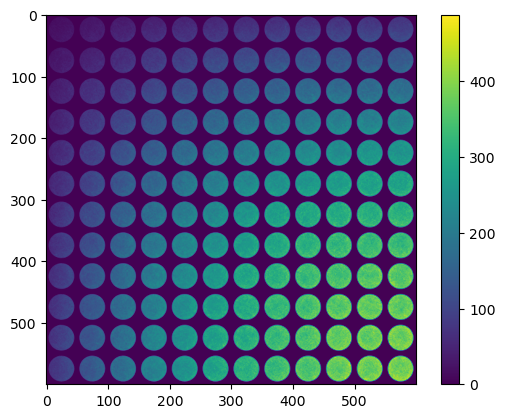

In [182]:
with openmc.StatePoint(statepoint) as sp:
    mesh_tally_out = sp.get_tally(id=heat.id)

a = mesh_tally_out.get_values()
mesh_flux = a.reshape(mesh.dimension)

plt.figure()
img = plt.imshow(mesh_flux)
plt.colorbar(img)


array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        28.20025877, 107.29488646, 111.48827396,  88.06247297,
        96.483766  , 119.25728546,  98.0403251 , 108.31467188,
       105.18225764,  98.30118433, 103.88954324,  95.96670443,
        95.10258428,  99.20339847,  99.8595695 ,  94.06731074,
        99.80222862, 103.05247047,  93.93246081,  87.32165263,
        86.01450224,  98.66376533,  89.67735322,  87.92587976,
        90.74010686,  91.71487287,  99.69788564,  87.8616694 ,
       101.67868025,  84.53924743,  92.20213438,  99.88851162,
        89.68785715, 100.00721647,  97.50159973,  94.31192699,
        95.80929106, 103.99196464, 103.65467505,  97.62600585,
        96.42860865, 100.06357098,  94.35384274,  92.82076847,
        96.68185562, 102.67096919,  96.2899439 ,  96.89779487,
        96.31499295,  91.5080831 ,  91.00326695,  95.40102319,
        91.51133667,  94.89805421,  99.51534412, 103.35